## Импорт необходимых библиотек:

In [190]:
import itertools as it

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
sns.set()

plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"""
\input glyphtounicode.tex 
\input glyphtounicode-cmr.tex 
\pdfgentounicode=1 
\usepackage{cmap}                           
\defaulthyphenchar=127              
\usepackage[T2A]{fontenc}                   
\usepackage[utf8]{inputenc}              
\usepackage[english,russian]{babel} 
"""

## Импорт рассматриваемого датасета:
Данные, в которых были 0,  были заменены на NaN (за исключением столбца "Pregancies").\
На экран выводятся верхние пять строк датасета, а также различная информация о нём.\
Можно заметить, что в столбце "Insulin" отсутствует очень много значений.

In [191]:
data = pd.read_csv("diabetes.csv", na_values = 0)
data["Outcome"].fillna(0, inplace = True)
data["Outcome"] = data["Outcome"].astype(int)
data["Pregnancies"].fillna(0, inplace = True)
data["Pregnancies"] = data["Pregnancies"].astype(int)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [192]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Построение матриц ковариации и корреляции:

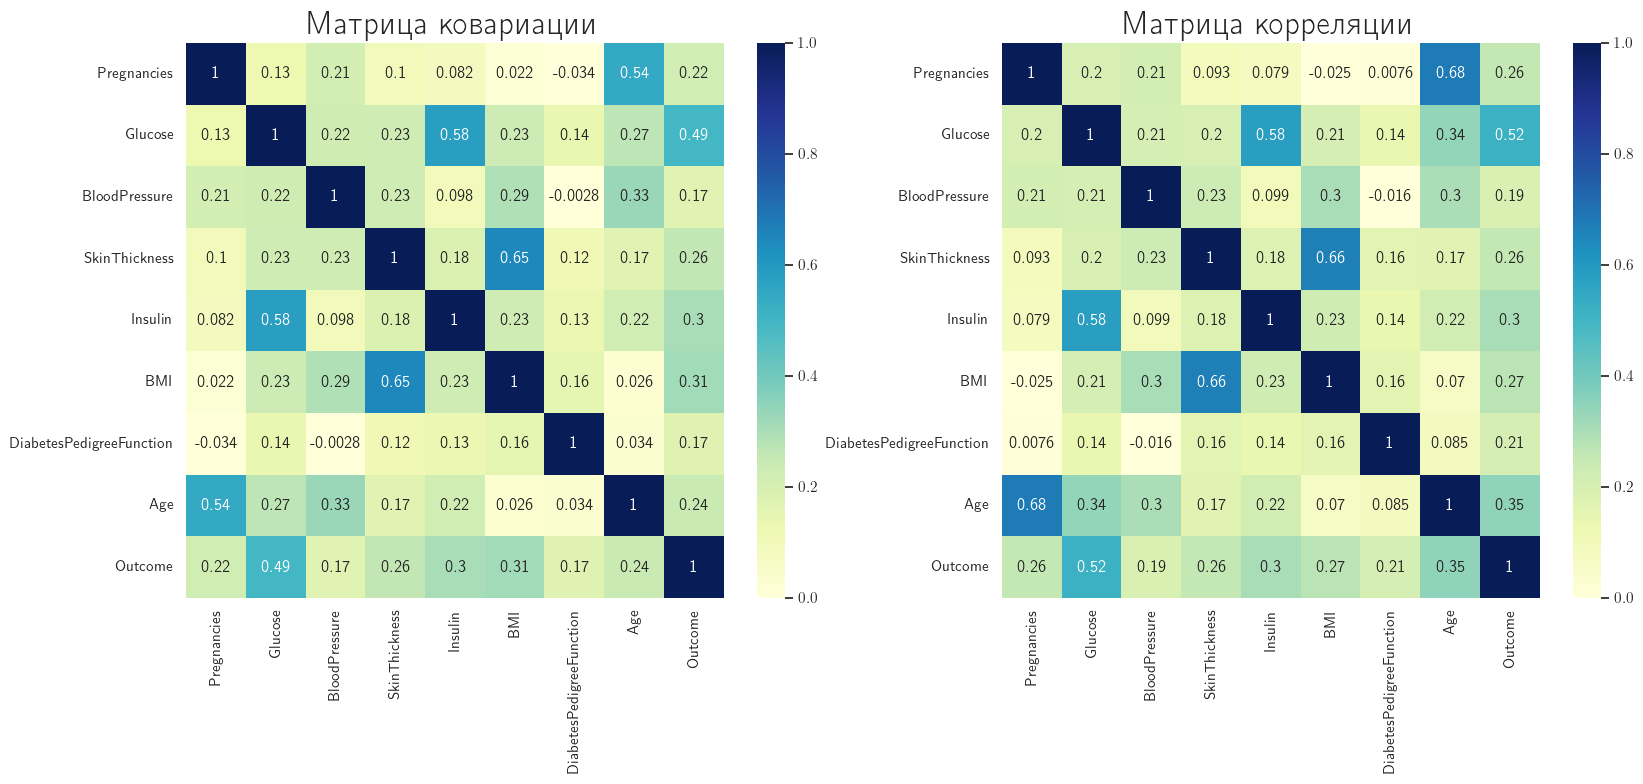

In [193]:
dic = {i: k for i,k in enumerate(list(data.columns))}
data_np = data.dropna().T
cov = np.cov(data_np, bias = True)
d = np.diagonal(cov)**0.5
d2 = d[:,np.newaxis]
cov = pd.DataFrame((cov/d)/d2)
cov = cov.rename(columns = dic, index = dic)

fig = plt.figure(layout = "tight", figsize = (17,8))
ax_left = fig.add_subplot(121)
ax_right = fig.add_subplot(122)
sns.heatmap((data.iloc[:,:]).corr(), cmap = "YlGnBu", annot = True, vmin = 0, vmax = 1, ax = ax_left)
sns.heatmap(cov, cmap = "YlGnBu", annot = True, vmin = 0, vmax = 1, ax = ax_right)
ax_left.set_title("Матрица ковариации", size = 25)
ax_right.set_title("Матрица корреляции", size = 25)
pass

## Обзор имеющихся данных:
Из круговой диаграммы видно, что количество отрицательных диагнозов преобладает над положительными

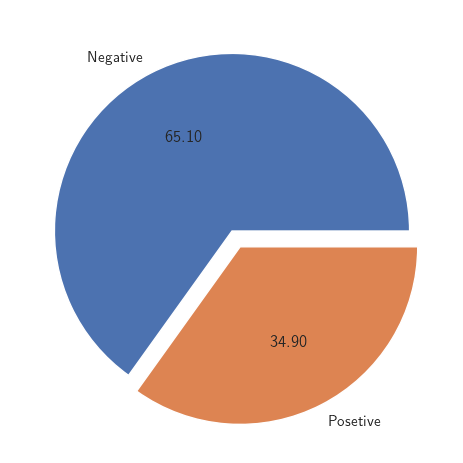

In [194]:
fig, ax = plt.subplots(layout = "tight")
labels = ["Negative","Posetive"]
alp = [0, 0.1]
ax.pie(data["Outcome"].value_counts(), labels = labels, explode = alp, autopct = "%1.2f%%" )
ax_left.set_title("Матрица ковариации", size = 25)
pass

В столбце Pregnancies 768 значений, из которых 0 пустые

В столбце Glucose 768 значений, из которых 5 пустые

В столбце BloodPressure 768 значений, из которых 35 пустые

В столбце SkinThickness 768 значений, из которых 227 пустые

В столбце Insulin 768 значений, из которых 374 пустые

В столбце BMI 768 значений, из которых 11 пустые

В столбце DiabetesPedigreeFunction 768 значений, из которых 0 пустые

В столбце Age 768 значений, из которых 0 пустые



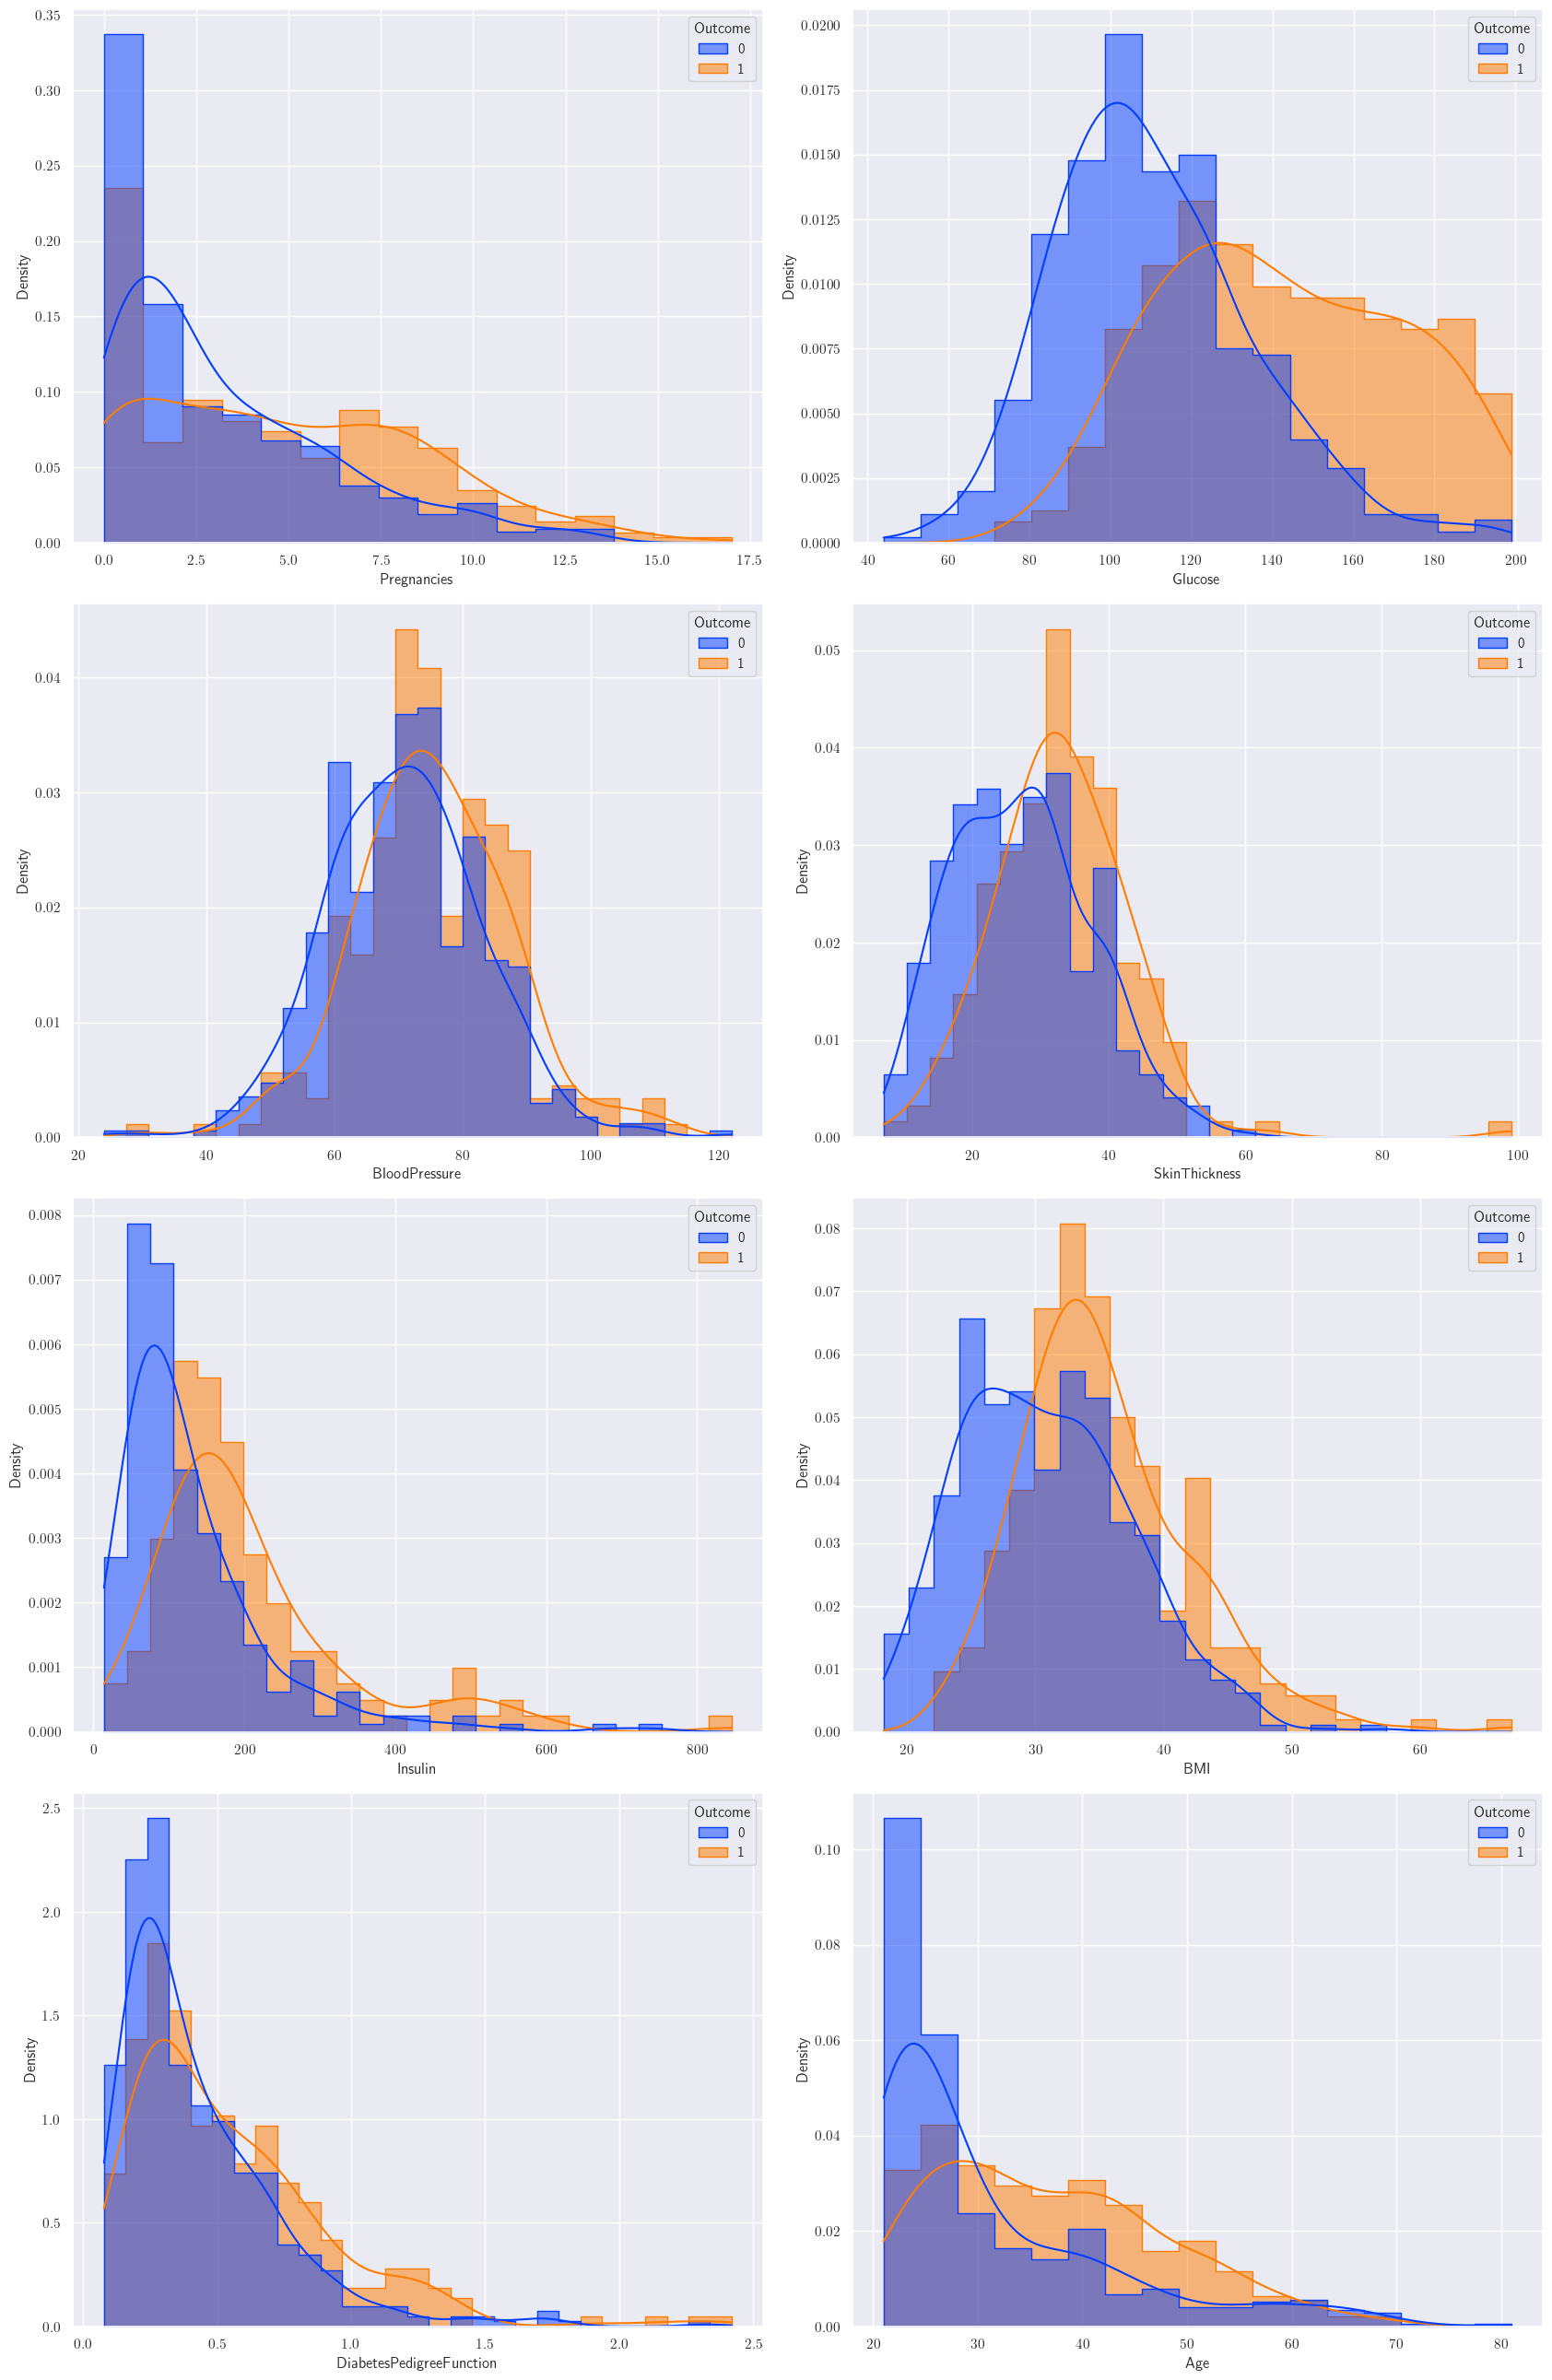

In [195]:
lenofnan = data.loc[~(data["Pregnancies"].notnull()), "Pregnancies"].size
lenofcol = data["Pregnancies"].size
fig = plt.figure(layout = "tight", figsize = (17,26))
for k,label in enumerate(data.columns[:-1]):
    lenofnan = data.loc[~(data[label].notnull()), label].size
    lenofcol = data[label].size
    print(f"В столбце {label} {lenofcol} значений, из которых {lenofnan} пустые")
    print()
    ax = fig.add_subplot(4,2,k+1)
    sns.histplot(data = data, x = label, alpha = 0.5, palette = "bright",\
        kde = True, ax = ax, stat="density",common_norm=False, element = "step", hue = "Outcome")

## Класс, для работы с датасетом:

In [196]:
class FillData:
    
    # Инициализация функции
    def __init__(self, data, categories, numbers_to_fill):
        self.raw_data = data
        self.categories = categories
        #self.main_func = main_func
        self.numbers_to_fill = numbers_to_fill
    
    # Функция считающая вероятности
    def count_p (self, numb_arr, indx_arr):
        data_w=self.raw_data.iloc[:,numb_arr].dropna().to_numpy()
        data_w.astype(np.longfloat)
        for i in range(1, numb_arr.size):
            data_w = data_w[np.where((data_w[:,i] < self.categories[numb_arr[i], indx_arr[i]+1]) & (data_w[:,i] >= self.categories[numb_arr[i], indx_arr[i]]))[0],:]
        s = np.longfloat(data_w.shape[0])
        if data_w.shape[0] == 0:
            return 0
        answ = (data_w[np.where((data_w[:,0] < self.categories[numb_arr[0], indx_arr[0]+1]) & (data_w[:,0] >= self.categories[numb_arr[0], indx_arr[0]]))[0],:]).shape[0]/s
        return answ
    
    # Функция, по которой читается совместная вероятность
    def main_funс(self, vals):
        count_p = self.count_p
        return(count_p(np.array([8,3,4,1]),np.array([vals[8],vals[3],vals[4],vals[1]])) *\
            count_p(np.array([6]), np.array([vals[6]])) * count_p(\
            np.array([3,5,1,4]), np.array([vals[3], vals[5], vals[1], vals[4]])) * count_p(np.array([1,7]), \
            np.array([vals[1],vals[7]])) * count_p(np.array([5, 4]),\
            np.array([vals[5], vals[4]])) * count_p(np.array([4,7,1,6]), np.array([vals[4], vals[7], vals[1],vals[6]]))\
            * count_p(np.array([7]),np.array([vals[7]])) * count_p(np.array([0,7]),\
            np.array([vals[0], vals[7]])) * count_p(np.array([2, 7, 5]),\
            np.array([vals[2], vals[7], vals[5]])))
    
    # Функция сопоставляющая каждому эллкменту в строке его категорию
    def check_category(self, arr):
        arr = arr[:,np.newaxis]
        answ = (self.categories < arr).sum(axis = 1) -1
        answ[-1] = 0
        return answ
    
    #Функция, заполняющая датасет
    def fill_y(self):
        indx = np.array([])
        data_renamed = self.raw_data.copy()
        for j in range(self.raw_data.shape[0]):
            row = data_renamed.iloc[j,:].to_numpy()
            cats, nans = self.check_category(row), np.where(np.isnan(row))[0]
            #nans = np.where(np.isnan(row))[0]
            for i1 in nans:
                gen_sum, summ = 0, np.array([])
                #summ = np.array([])
                for i2 in range(4):
                    cats2, s = cats.copy(), 0
                    #s = 0
                    cats2[i1], x = i2, list(it.product([0,1,2,3],repeat = (nans.size -1) ))
                    #x= list(it.product([0,1,2,3],repeat = (nans.size -1) ))
                    for i3 in x:
                        cats3 = cats2.copy()
                        cats3[cats3 == -1] = i3
                        gen_sum += (self.main_funс(np.append(cats3[:-1], 0)) + \
                                    self.main_funс(np.append(cats3[:-1], 2)))
                        s += (self.main_funс(np.append(cats3[:-1], 0)) + \
                                    self.main_funс(np.append(cats3[:-1], 2)))
                    summ = np.append(summ, s)
                answ = summ/gen_sum
                row[i1] = self.numbers_to_fill[i1,0]*answ[0]+self.numbers_to_fill[i1,1]*answ[1]\
                              +self.numbers_to_fill[i1,2]*answ[2]+self.numbers_to_fill[i1,3]*answ[3]
            if 4 in nans:
                indx = np.append(indx, j)
            data_renamed.iloc[j,:] = row
        return data_renamed, indx
    
    #Модель, предсказывающая диагноз
    def predict_o(self, data_train, data_test):
        preds = np.array([])
        dat = self.raw_data
        self.raw_data = data_train
        for i in range(data_test.shape[0]):
            row = data_test.iloc[i,:].to_numpy()
            row = np.append(row, 0)
            cats = self.check_category(row)
            cats = cats[:-1]
            if ((self.main_funс(np.hstack((cats,0))\
                )) + (self.main_funс(np.hstack((cats,3))))) == 0:
                for i in [6,0,2,7,5,3,4,1]:
                    gen_sum = 0
                    summ = 0
                    for j in range(4):
                        cats2 = cats.copy()
                        cats2[i] = j
                        summ+= self.main_funс(np.hstack((cats2,0)))
                        gen_sum+= self.main_funс(np.hstack((cats2,3)))+\
                        self.main_funс(np.hstack((cats2,0)))
                    if gen_sum!=0:
                        score = summ/gen_sum
                        break
            else:
                score = self.main_funс(np.hstack((cats,0)))/((self.main_funс(np.hstack((cats,0))\
                    )) + (self.main_funс(np.hstack((cats,3)))))
            if score > 0.53:
                preds = np.append(preds, 0)
            else:
                preds = np.append(preds, 1)
        self.raw_data = dat
        return(preds)

## Заполнение пропущенных данных и визуализация:

In [197]:
numbers_to_fill = np.array([[0,3,5,10],[83.3,109.7,134.2,168],[57.8,72.2,84.8,96],[13.7,20.88,30.27,42.8],\
                   [43.6,101.97,214.13,260],[22.59,31.12,49.48,46.95],[0.18,0.48,1.09,1.81],[24,32,40,55]])
categories = np.array([[-0.01,1,4,8,210], [0,95,125,140,3000], [0,65,80,90,2000], [0,18,25,37,800],[0,60, 150,350,10000]\
                       ,[0,25,37,43,800], [-0.1, 0.25, 0.9, 1.4, 30], [0, 30, 36, 46, 1000], [0,0.1,0,0.1, 1.1]])

obj = FillData(data, categories, numbers_to_fill)
data_new, indx = obj.fill_y()
print(data_new.shape)

/var/folders/y_/3dh1k_c15tx0dd5d4w65dd4w0000gn/T/ipykernel_92199/1817620821.py:65: RuntimeWarning: invalid value encountered in true_divide
  answ = summ/gen_sum


(768, 9)


In [198]:
data_new_ch = data_new.dropna()
data_new_ch

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,175.951579,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,43.600000,26.6,0.351,31,0
2,8,183.0,64.0,22.620125,137.419228,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.000000,180.000000,32.9,0.171,63,0
764,2,122.0,70.0,27.000000,121.545802,36.8,0.340,27,0
765,5,121.0,72.0,23.000000,112.000000,26.2,0.245,30,0
766,1,126.0,60.0,26.407398,127.926797,30.1,0.349,47,1


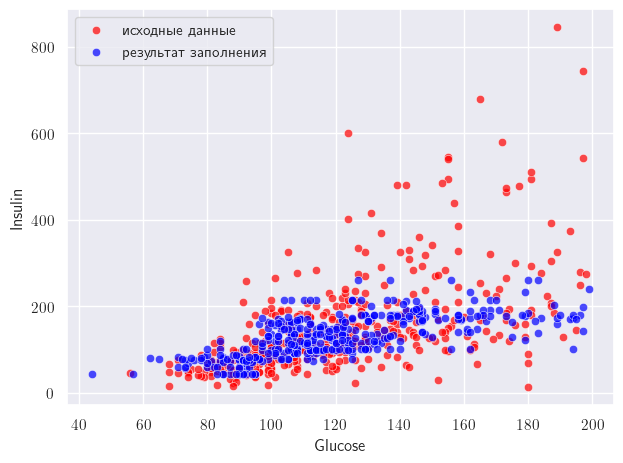

In [239]:
fig, ax = plt.subplots(layout = "tight")
sns.scatterplot(data = data, x = "Glucose", y = "Insulin", color= "red", ax = ax, alpha = 0.7)
sns.scatterplot(data = data_new.iloc[indx, :], x = "Glucose", y = "Insulin",color ="blue",ax = ax, alpha = 0.7)
ax.legend(labels = ["исходные данные", "результат заполнения"])

## Предсказание модели:

In [177]:
index = np.array([0,1,2,3,4,5,6,7])
X = data_new_ch.iloc[:, index].to_numpy()
Y = data_new_ch.iloc[:,8].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
preds = obj.predict_o(pd.DataFrame(np.hstack((X_train, Y_train[:, np.newaxis]))), pd.DataFrame(X_test))
score_bs = accuracy_score(preds, Y_test)
precision_bs = precision_score(preds, Y_test)
recall_bs = recall_score(preds, Y_test)
f1_bs = f1_score(preds, Y_test)
print(f"score: {score_bs}, precision: {precision_bs}, recall: {recall_bs}, f1: {f1_bs}")

score: 0.8421052631578947, precision: 0.8, recall: 0.7407407407407407, f1: 0.7692307692307692


## Сравнение с другими моделями:

In [188]:
xgb_clsf = XGBClassifier(n_estimators = 9, max_depth = 1, learning_rate = 1.2, random_state = 42)
xgb_clsf.fit(X_train, Y_train)
preds = xgb_clsf.predict(X_test)
score_xgb = accuracy_score(preds, Y_test)
precision_xgb = precision_score(preds, Y_test)
recall_xgb = recall_score(preds, Y_test)
f1_xgb = f1_score(preds, Y_test)
print(f"score: {score_xgb}, precision: {precision_xgb}, recall: {recall_xgb}, f1: {f1_xgb}")

score: 0.9210526315789473, precision: 0.92, recall: 0.8518518518518519, f1: 0.8846153846153846


In [211]:
clsf_tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 3, random_state = 42)
clsf_tree.fit(X_train, Y_train)
preds = clsf_tree.predict(X_test)
score_dt = accuracy_score(preds, Y_test)
precision_dt = precision_score(preds, Y_test)
recall_dt = recall_score(preds, Y_test)
f1_dt = f1_score(preds, Y_test)
print(f"score: {score_dt}, precision: {precision_dt}, recall: {recall_dt}, f1: {f1_dt}")

score: 0.8421052631578947, precision: 0.52, recall: 1.0, f1: 0.6842105263157895


In [216]:
scaler = StandardScaler()
data_skaled = scaler.fit_transform(data_new_ch.iloc[:,:-1])
X = data_skaled[:, index]
Y = data_new_ch.iloc[:,8].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
clsf = SVC(C = 5, random_state = 42, kernel = "rbf")
clsf.fit(X_train, Y_train)
preds = clsf.predict(X_test)
score_svc = accuracy_score(preds, Y_test)
precision_svc = precision_score(preds, Y_test)
recall_svc = recall_score(preds, Y_test)
f1_svc = f1_score(preds, Y_test)
print(f"score: {score_svc}, precision: {precision_svc}, recall: {recall_svc}, f1: {f1_svc}")

score: 0.8026315789473685, precision: 0.68, recall: 0.7083333333333334, f1: 0.6938775510204083


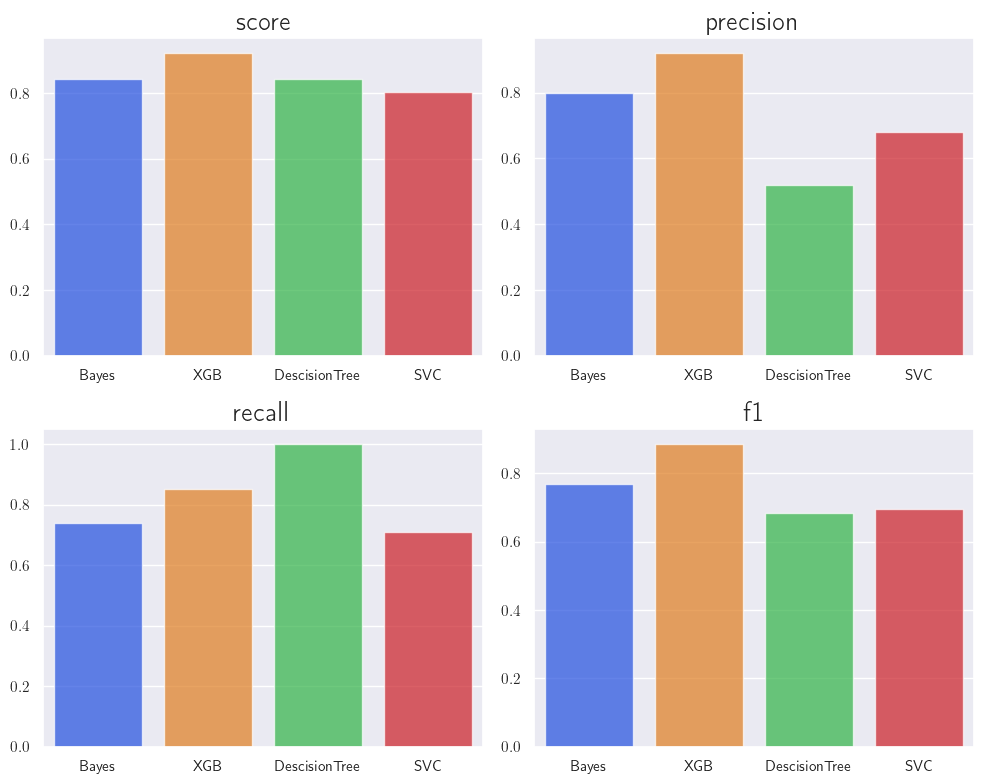

In [236]:
fig = plt.figure(layout = "tight", figsize = (10,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.barplot(x = ["Bayes","XGB", "DescisionTree", "SVC"], y = [score_bs,score_xgb,score_dt,score_svc], ax = ax1, palette = "bright", alpha = 0.7)
sns.barplot(x = ["Bayes","XGB", "DescisionTree", "SVC"], y = [precision_bs,precision_xgb,precision_dt,precision_svc], ax = ax2, palette = "bright", alpha = 0.7)
sns.barplot(x = ["Bayes","XGB", "DescisionTree", "SVC"], y = [recall_bs,recall_xgb,recall_dt,recall_svc], ax = ax3, palette = "bright", alpha = 0.7)
sns.barplot(x = ["Bayes","XGB", "DescisionTree", "SVC"], y = [f1_bs,f1_xgb,f1_dt,f1_svc], ax = ax4, palette = "bright", alpha = 0.7)
ax1.set_title("score", fontsize = 20)
ax2.set_title("precision", fontsize = 20)
ax3.set_title("recall", fontsize = 20)
ax4.set_title("f1", fontsize = 20)
pass